In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import nearest_points, split, linemerge
import os
import parse_functions

%matplotlib inline

# Load GTFS text files
Files can downloaded from [transitfeeds.com](https://transitfeeds.com/p/utah-transportation-authority/59). 

Unzip all the GTFS files and set `gtfs_dir` to the directory where the files are stored.

In [2]:
gtfs_dir = '../gtfs Nov 18'
routes = pd.read_csv(os.path.join(gtfs_dir, 'routes.txt'))
shapes = pd.read_csv(os.path.join(gtfs_dir, 'shapes.txt'))
trips = pd.read_csv(os.path.join(gtfs_dir, 'trips.txt'))
stops = pd.read_csv(os.path.join(gtfs_dir, 'stops.txt'))
stop_times = pd.read_csv(os.path.join(gtfs_dir, 'stop_times.txt'), dtype={'stop_id': object})
calendar = pd.read_csv(os.path.join(gtfs_dir, 'calendar.txt'))

# Join shape polylines to trips

In [3]:
line_shapes = parse_functions.transform_shape_to_lines(shapes)  # Convert GTFS shapes to polylines

In [4]:
shape_geom = 'coords'
line_shapes[shape_geom] = line_shapes[shape_geom].to_crs(epsg=3857) # project the WGS84 coordinates to Web Mercator 
line_shapes.head(3)

,shape_id,shape_dist_traveled,coords
shape_id,,,
168743,168743,1360.3743,LINESTRING (-12457664.02713353 4977473.2725649...
168744,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...
168745,168745,1175.5721,LINESTRING (-12456318.17448984 4971819.3894373...


In [5]:
trips.head(3)

,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id
0,a_985380,74656,0,Midvale,168897,16_merged_3782680,3569248
1,a_985380,74656,0,Midvale,168897,16_merged_3782680,3569249
2,a_985379,74656,0,Midvale,168897,16_merged_3782680,3569244


## Select trips by route and number of stops

In [6]:
stop_times.set_index('trip_id', inplace=True)
trips.set_index('trip_id', inplace=True)
trip_stops = trips.join(stop_times, lsuffix='', rsuffix='_stops')
stop_times.reset_index(inplace=True)
trip_stops = trip_stops.reset_index()
trip_stops.head()

,trip_id,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:24:00,08:24:00,21168,1,NaN,NaN,NaN,NaN,NaN
1,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:29:14,08:29:14,5479,2,NaN,NaN,NaN,NaN,NaN
2,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:29:57,08:29:57,24221,3,NaN,NaN,NaN,NaN,NaN
3,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:30:57,08:30:57,5481,4,NaN,NaN,NaN,NaN,NaN
4,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:32:13,08:32:13,13105,5,NaN,NaN,NaN,NaN,NaN


In [7]:
route_shapes = trip_stops.groupby(['route_id', 'trip_id']).agg(['count'])['stop_id']
route_shape_counts = route_shapes.reset_index()
idx = route_shape_counts.groupby(['route_id'])['count'].transform(max) == route_shape_counts['count']
top_stop_trips = route_shape_counts[idx]
selected_trip_ids = top_stop_trips.groupby(['route_id']).first()
selected_trip_ids.head()

,trip_id,count
route_id,,
74606,3522196,40
74607,3522214,34
74608,3522339,22
74609,3522785,50
74610,3523164,45


In [8]:
selected_trip_ids.reset_index(inplace=True)
selected_index = selected_trip_ids.set_index('trip_id').index
selected_index
selected_trips = trips.loc[selected_index]
selected_trips.shape

(243, 6)

In [9]:
selected_trips.reset_index(inplace=True)
selected_trips.set_index('shape_id')
trip_shapes = selected_trips.join(line_shapes, on='shape_id', lsuffix='', rsuffix='_shapes')

In [10]:
trip_shapes.head()

,trip_id,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,shape_id_shapes,shape_dist_traveled,coords
0,3522196,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...
1,3522214,a_981139,74607,0,University of Utah,168745,4_merged_3782668,168745,1175.5721,LINESTRING (-12456318.17448984 4971819.3894373...
2,3522339,a_981171,74608,0,University Medical Center,168747,2_merged_3782667,168747,644.1306,LINESTRING (-12457664.02713353 4977473.2725649...
3,3522785,a_981256,74609,0,Murray Central Station,168749,2_merged_3782667,168749,2600.1962,LINESTRING (-12457664.02713353 4977473.2725649...
4,3523164,a_981321,74610,0,South Jordan Station,168751,2_merged_3782667,168751,2130.0770,LINESTRING (-12456139.95198508 4962242.4323916...


Check for trips that didn't join

In [11]:
len(trip_shapes.loc[trip_shapes['shape_id_shapes'].isnull()])

0

In [12]:
trip_shapes = gpd.GeoDataFrame(trip_shapes, geometry=shape_geom)
trip_shapes.crs = {'init': 'epsg:3857'}

# Create stop points

In [13]:
stop_points = parse_functions.transform_stops_to_points(stops)
stop_points.crs = {'init': 'epsg:4326'}
stop_points['geometry'] = stop_points['geometry'].to_crs(epsg=3857)
stop_points.head(3)

,stop_lat,stop_code,stop_lon,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id,geometry,stop_id
stop_id,,,,,,,,,,,
11541,41.166905,629050,-111.962747,NaN,NaN,E 5300 S,5300 S @ 711 E,0,NaN,POINT (-12463635.98385612 5036991.371158207),11541
11546,41.206463,623264,-111.970663,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3180 S,0,NaN,POINT (-12464517.18894524 5042842.771688678),11546
11544,41.199655,623261,-111.970843,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3500 S,0,NaN,POINT (-12464537.22645358 5041835.483675041),11544


# Join stop points to stop times

In [14]:
stop_times.set_index('stop_id', inplace=True)
stop_times.head()
stop_time_points = stop_times.join(stop_points, lsuffix='', rsuffix='_stops')
len(stop_time_points.loc[stop_time_points['stop_id'].isnull()])

0

In [15]:
stop_time_points.head(3)

,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_lat,stop_code,stop_lon,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id,geometry,stop_id
stop_id,,,,,,,,,,,,,,,,,,,,
1022,3762571,14:33:00,14:33:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
1022,3762570,18:33:00,18:33:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
1022,3762573,08:03:00,08:03:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022


In [16]:
stop_time_points = gpd.GeoDataFrame(stop_time_points, geometry='geometry')
stop_time_points.crs = {'init' :'epsg:3857'}

In [17]:
len(stop_time_points)

1414481

# Get the route shape for each stop

In [18]:
trip_shapes.head(3)

,trip_id,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,shape_id_shapes,shape_dist_traveled,coords
0,3522196,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...
1,3522214,a_981139,74607,0,University of Utah,168745,4_merged_3782668,168745,1175.5721,LINESTRING (-12456318.17448984 4971819.3894373...
2,3522339,a_981171,74608,0,University Medical Center,168747,2_merged_3782667,168747,644.1306,LINESTRING (-12457664.02713353 4977473.2725649...


In [19]:
stop_time_points.set_index('trip_id', inplace=True)
trip_shapes.set_index('trip_id', inplace=True)

In [20]:
stop_time_points.head()

,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_lat,stop_code,stop_lon,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id,geometry,stop_id
trip_id,,,,,,,,,,,,,,,,,,,
3762571,14:33:00,14:33:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
3762570,18:33:00,18:33:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
3762573,08:03:00,08:03:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
3762572,12:03:00,12:03:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022
3762575,15:33:00,15:33:00,86,NaN,NaN,NaN,NaN,NaN,40.772535,118161,-111.837594,NaN,NaN,NORTH MEDICAL DR,NORTH MEDICAL DR @ 50 N,0,NaN,POINT (-12449704.01562487 4978848.301317408),1022


In [21]:
stop_time_points = stop_time_points.loc[trip_shapes.index]

In [22]:
stop_trip_geo = stop_time_points.join(trip_shapes, lsuffix='', rsuffix='_trips')

In [23]:
stop_trip_geo.head(3)

,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_lat,stop_code,...,stop_id,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,shape_id_shapes,shape_dist_traveled_trips,coords
trip_id,,,,,,,,,,,,,,,,,,,,,
3522196,09:03:00,09:03:00,1,NaN,NaN,NaN,NaN,NaN,40.772535,118161,...,1022,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...
3522196,09:04:00,09:04:00,2,NaN,NaN,NaN,NaN,NaN,40.772482,118159,...,13100,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...
3522196,09:20:36,09:20:36,32,NaN,NaN,NaN,NaN,NaN,40.770391,118003,...,13182,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...


# Check the stop distance to the end points of a trip shape
If all trip shapes have a stop near the end points we can assume a person can exit transit at the end of each line.

In [24]:
shape_stop_group = stop_trip_geo.groupby(['shape_id', 'trip_id'])

In [25]:
shape_stop_group.size().head()

shape_id  trip_id
168744    3522196    40
168745    3522214    34
168747    3522339    22
168749    3522785    50
168751    3523164    45
dtype: int64

In [26]:
shape_stop_group.get_group((168744,  3522196))['geometry'].head(5)

trip_id
3522196    POINT (-12449704.01562487 4978848.301317408)
3522196    POINT (-12450244.69439165 4978840.510657349)
3522196    POINT (-12455361.38346647 4978533.152027944)
3522196    POINT (-12455771.26183157 4977757.081459908)
3522196    POINT (-12456392.98118765 4977758.404255008)
Name: geometry, dtype: object

In [27]:
shape_stop_check = shape_stop_group.agg({
    'shape_id': 'first',
    'geometry': lambda s: MultiPoint(s.tolist()), # Make a multipoint
    shape_geom: 'first'})

In [28]:
shape_stop_check.head()

,,shape_id,geometry,coords
shape_id,trip_id,,,
168744,3522196,168744,"(POINT (-12449704.01562487 4978848.301317408),...",LINESTRING (-12449699.11756727 4978829.7801357...
168745,3522214,168745,"(POINT (-12450611.7147528 4975499.037410892), ...",LINESTRING (-12456318.17448984 4971819.3894373...
168747,3522339,168747,"(POINT (-12449704.01562487 4978848.301317408),...",LINESTRING (-12457664.02713353 4977473.2725649...
168749,3522785,168749,"(POINT (-12455364.6117317 4977306.165746813), ...",LINESTRING (-12457664.02713353 4977473.2725649...
168751,3523164,168751,"(POINT (-12456038.76256795 4962098.4773773), P...",LINESTRING (-12456139.95198508 4962242.4323916...


## Get start and end points of trip line

In [29]:
shape_stop_check['line_start'] = shape_stop_check[shape_geom].apply(lambda l: Point(l.coords[0]))

In [30]:
shape_stop_check['line_end'] = shape_stop_check[shape_geom].apply(lambda l: Point(l.coords[-1]))

In [31]:
shape_stop_check.head()

,,shape_id,geometry,coords,line_start,line_end
shape_id,trip_id,,,,,
168744,3522196,168744,"(POINT (-12449704.01562487 4978848.301317408),...",LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12449699.11756727 4978829.780135744),POINT (-12457672.9326928 4977474.742294595)
168745,3522214,168745,"(POINT (-12450611.7147528 4975499.037410892), ...",LINESTRING (-12456318.17448984 4971819.3894373...,POINT (-12456318.17448984 4971819.389437355),POINT (-12449858.30443911 4978468.330137447)
168747,3522339,168747,"(POINT (-12449704.01562487 4978848.301317408),...",LINESTRING (-12457664.02713353 4977473.2725649...,POINT (-12457664.02713353 4977473.272564956),POINT (-12449699.11756727 4978829.780135744)
168749,3522785,168749,"(POINT (-12455364.6117317 4977306.165746813), ...",LINESTRING (-12457664.02713353 4977473.2725649...,POINT (-12457664.02713353 4977473.272564956),POINT (-12456082.17716936 4962380.51966989)
168751,3523164,168751,"(POINT (-12456038.76256795 4962098.4773773), P...",LINESTRING (-12456139.95198508 4962242.4323916...,POINT (-12456139.95198508 4962242.432391632),POINT (-12456762.33925811 4948187.234945531)


## Find distance from trip's stops to the end points of the trip line

In [32]:
shape_stop_check['end_stop_dist'] = shape_stop_check.apply(lambda g: g.line_end.distance(g.geometry), axis=1)
shape_stop_check['start_stop_dist'] = shape_stop_check.apply(lambda g: g.line_start.distance(g.geometry), axis=1)

## Why is there no stop near some end and start points?

In [33]:
shape_stop_check['end_stop_dist'].sort_values(ascending=False).head(5)

shape_id  trip_id
175599    3716808    6184.550479
175598    3716776     390.046708
169271    3538841     327.497844
175781    3709204     327.497844
170482    3629331     281.117460
Name: end_stop_dist, dtype: float64

In [34]:
shape_stop_check['start_stop_dist'].sort_values(ascending=False).head(5)

shape_id  trip_id
175598    3716776    441.085412
175594    3716797    329.268112
170463    3629219    294.115050
175620    3761133    294.115050
169271    3538841    225.392719
Name: start_stop_dist, dtype: float64

# Mega split!

In [35]:
def add_points_into_line_no_overlap(multipoint, line):
    """
    Add points as line vertices.
    This method assumes line doesn't overlap it's self.
    """
    from operator import itemgetter
    line_points = []
    for p in multipoint:
        line_dist = line.project(p)
        line_points.append((line_dist, p))
    for c in line.coords:
        p = Point(c)
        line_dist = line.project(p)
        line_points.append((line_dist, p))
    
    line_points.sort(key=itemgetter(0))
    return LineString([t[1] for t in line_points])
    

In [36]:
def add_points_into_line(multipoint, line):
    """
    Add points as line vertices.
    """
    line_points = []
    points = []
    for p in multipoint:
        line_dist = line.project(p)
        points.append((line_dist, p))
    
    total_dist = 0
    for pos, c in enumerate(line.coords):
        vertex = Point(c)
        last_vertex = None
        if pos != 0:
            last_vertex = Point(line.coords[pos - 1])
        else:
            last_vertex = vertex
        
        v_dist = total_dist + last_vertex.distance(vertex)
        total_dist = v_dist

        rem = []
        for i, p in enumerate(points):
            p_dist, point = p
            if p_dist <= v_dist:
                 line_points.append(point)
                 rem.append(i)

        points = [pi for j, pi in enumerate(points) if j not in rem]

        line_points.append(vertex)
        
    return LineString(line_points)

## Get a point on the trip line for each bus stop

In [37]:
stop_trip_geo['nearest_stop'] = stop_trip_geo.apply(lambda x: nearest_points(x.geometry, x.coords)[1], axis=1)

In [38]:
stop_trip_geo.head()

,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_lat,stop_code,...,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,shape_id_shapes,shape_dist_traveled_trips,coords,nearest_stop
trip_id,,,,,,,,,,,,,,,,,,,,,
3522196,09:03:00,09:03:00,1,NaN,NaN,NaN,NaN,NaN,40.772535,118161,...,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12449709.7979358 4978843.939841886)
3522196,09:04:00,09:04:00,2,NaN,NaN,NaN,NaN,NaN,40.772482,118159,...,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12450233.03949522 4978833.365507327)
3522196,09:20:36,09:20:36,32,NaN,NaN,NaN,NaN,NaN,40.770391,118003,...,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12455344.1289454 4978533.152027944)
3522196,09:23:48,09:23:48,35,NaN,NaN,NaN,NaN,NaN,40.765111,125407,...,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12455771.07454152 4977743.60548726)
3522196,09:25:47,09:25:47,37,NaN,NaN,NaN,NaN,NaN,40.765120,125405,...,a_981126,74606,1,Salt Lake Central Station,168744,4_merged_3782668,168744,1397.7476,LINESTRING (-12449699.11756727 4978829.7801357...,POINT (-12456392.98118765 4977740.767001763)


## Export stops as points

In [39]:
stop_trip_geo.reset_index(inplace=True)
output_geo = gpd.GeoDataFrame(stop_trip_geo.loc[:,['shape_id', 'route_id', 'trip_id', 'stop_id', 'geometry']],
                              geometry='geometry')
output_geo.crs = {'init' :'epsg:3857'}
output_geo.to_file('data/split_shapes/gtfs_point_stops.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [40]:

shape_stop_split = shape_stop_group.agg({
    'shape_id': 'first',
    'route_id': 'first',
    'nearest_stop': lambda s: MultiPoint(s.tolist()), # Make a multipoint
    shape_geom: 'first'})

In [41]:
shape_stop_split.drop(['shape_id'], axis=1, inplace=True)
shape_stop_split.reset_index(inplace=True)
shape_stop_split.head()

,shape_id,trip_id,route_id,nearest_stop,coords
0,168744,3522196,74606,"(POINT (-12449709.7979358 4978843.939841886), ...",LINESTRING (-12449699.11756727 4978829.7801357...
1,168745,3522214,74607,"(POINT (-12450611.7147528 4975506.972349949), ...",LINESTRING (-12456318.17448984 4971819.3894373...
2,168747,3522339,74608,"(POINT (-12449699.11756727 4978829.780135744),...",LINESTRING (-12457664.02713353 4977473.2725649...
3,168749,3522785,74609,"(POINT (-12455340.78936068 4977306.165746813),...",LINESTRING (-12457664.02713353 4977473.2725649...
4,168751,3523164,74610,"(POINT (-12456048.75803478 4962103.102930346),...",LINESTRING (-12456139.95198508 4962242.4323916...


In [42]:
shape_stop_split.shape

(243, 5)

In [43]:
split_shape_group = shape_stop_split.groupby('shape_id')

In [44]:
split_shapes = shape_stop_split

## Add snapped stops as line vertices

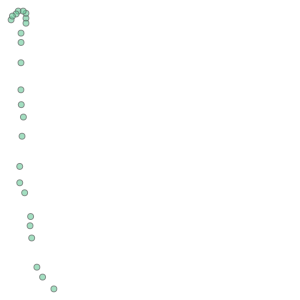

In [45]:
stops = split_shapes.iloc[108, :]['nearest_stop']
stops

In [46]:
unsplitline = split_shapes.iloc[108, :][shape_geom]

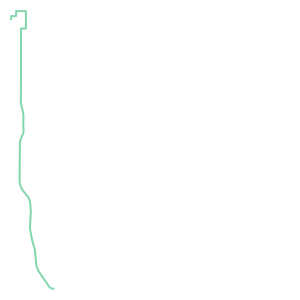

In [47]:
split = add_points_into_line(stops, unsplitline)
split

In [51]:
split_shapes['stop_split_line'] = split_shapes.apply(lambda x: add_points_into_line(x.nearest_stop, x.coords), axis=1)

In [52]:
split_shapes.head(3)

,shape_id,trip_id,route_id,nearest_stop,coords,stop_split_line
0,168744,3522196,74606,"(POINT (-12449709.7979358 4978843.939841886), ...",LINESTRING (-12449699.11756727 4978829.7801357...,LINESTRING (-12449699.11756727 4978829.7801357...
1,168745,3522214,74607,"(POINT (-12450611.7147528 4975506.972349949), ...",LINESTRING (-12456318.17448984 4971819.3894373...,LINESTRING (-12456318.17448984 4971819.3894373...
2,168747,3522339,74608,"(POINT (-12449699.11756727 4978829.780135744),...",LINESTRING (-12457664.02713353 4977473.2725649...,LINESTRING (-12457664.02713353 4977473.2725649...


# Write out data to shapefile

In [53]:
output_geo = gpd.GeoDataFrame(split_shapes.loc[:,['shape_id', 'trip_id', 'route_id', 'stop_split_line']],
                              geometry='stop_split_line')
output_geo.crs = {'init' :'epsg:3857'}
output_geo.to_file('data/split_shapes/shapes_stop_vertices.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [54]:
output_geo = gpd.GeoDataFrame(split_shapes.loc[:,['shape_id', 'trip_id', 'route_id', shape_geom]],
                              geometry=shape_geom)
output_geo.crs = {'init' :'epsg:3857'}
output_geo.to_file('data/split_shapes/gtfs_shapes.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [55]:
output_geo = gpd.GeoDataFrame(split_shapes.loc[:,['shape_id', 'trip_id', 'route_id', 'nearest_stop']],
                              geometry='nearest_stop')
output_geo.crs = {'init' :'epsg:3857'}
output_geo.to_file('data/split_shapes/line_snapped_stops.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
